# Session 7 Assignment:
Fix the code such that:
* The code uses GPU 
* The architecture is C1-C2-C3-C4-O (basically 3 MPs)
* Total RF must be more than 44
* One of the layers must use Depthwise Separable Convolution
* One of the layers must use Dilated Convolution
* Use GAP (mandatory), add FC after GAP to target the number of classes
* Achieve 80% accuracy with as many epochs as needed
* Total parameters must be less than 1M

In [1]:
# Google drive mount
from google.colab import drive 

# Prompt for google drive authorization
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [2]:
# change the current directory to the directory of .py files
%cd /content/gdrive/My\ Drive/Academics/Preparation/Deep\ learning/EVA4/S7/helper_files

/content/gdrive/My Drive/Academics/Preparation/Deep learning/EVA4/S7/helper_files


In [3]:
# Installing external libraries
!pip install torchsummary

## Import Libraries

In [4]:
import os
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torchsummary import summary
from cuda_setup import set_device
from loaders import generate_train_test_loader
from data_utils import data_statistics, visualize_data
from models import CIFAR10_Net
from training import train
from testing import test
from results import visualize_graph, visualize_predictions, visualize_misclassified, classwise_accuracy
%matplotlib inline

## Initial Setup

Set up the path for saving models, graphs and images.

In [5]:
# Google drive file path
os.chdir('/content/gdrive/My Drive/colab_folder/')
filepath = os.getcwd()
print(filepath)

/content/gdrive/My Drive/colab_folder


## Hyperparameters

In [6]:
input_size = (3, 32, 32)
EPOCHS = 10 
lr = 0.01 
momentum = 0.9
weight_decay = 0.0003
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
train_loss = list()
train_accuracy = list()
test_loss = list()
test_accuracy = list()
misclassified = list()

## Run the Models

In [7]:
device = set_device()
print('Using', device, '!')

training, testing, train_loader, test_loader = generate_train_test_loader()
print('\nDataloaders generated!')

data_statistics(training, train_loader, testing, test_loader)
print('\nData statistics generated!')

Using cuda !
Files already downloaded and verified
Files already downloaded and verified

Dataloaders generated!

Training data statistics:
 - Numpy Shape: (50000, 3, 32, 32)
 - Tensor Shape: torch.Size([50000, 3, 32, 32])
 - min: -1.989232063293457
 - max: 2.1267404556274414
 - mean: -0.04767431318759918
 - std: 1.0275938510894775
 - var: 1.055949091911316
 - Images Shape: torch.Size([128, 3, 32, 32])
 - Labels: torch.Size([128])

Test data statistics:
 - Numpy Shape: (10000, 3, 32, 32)
 - Tensor Shape: torch.Size([10000, 3, 32, 32])
 - min: -1.989232063293457
 - max: 2.1267404556274414
 - mean: 0.012808261439204216
 - std: 0.9986770153045654
 - var: 0.9973557591438293
 - Images Shape: torch.Size([128, 3, 32, 32])
 - Labels: torch.Size([128])

Data statistics generated!


Visualizing the training and test data

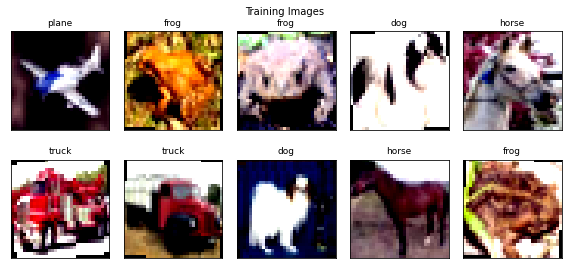

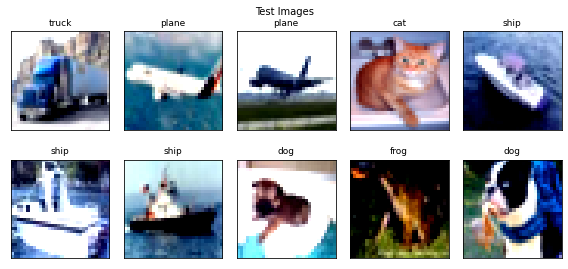

In [8]:
visualize_data(train_loader, test_loader, classes)

In [9]:
model = CIFAR10_Net().to(device)
optimizer = optim.SGD(model.parameters(), 
                      lr = lr, 
                      momentum = momentum, 
                      weight_decay = weight_decay)
scheduler = OneCycleLR(optimizer,
                       max_lr=0.1,
                       total_steps=10) 
print('\nCreated the model and the optimizer!')

print('\nModel summary:')
summary(model, input_size = input_size)


Created the model and the optimizer!

Model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,728
       BatchNorm2d-8          [-1, 128, 32, 32]             256
              ReLU-9          [-1, 128, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]           8,192
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
        MaxPool2d-13           [-1, 64, 16, 16]  

In [10]:
print('\nTraining the model...')
print('*' * 60)

for epoch in range(EPOCHS):
  train(model, device, train_loader, optimizer, epoch, EPOCHS, train_loss, train_accuracy) 
  scheduler.step()
  test(model, device, test_loader, test_loss, test_accuracy, classes, misclassified)

print('Saving the model and the optimizer...')
torch.save(model.state_dict(), filepath + '/EVA_models/cifar10_model.pth')
torch.save(optimizer.state_dict(), filepath + '/EVA_models/cifar10_optimizer.pth')

  0%|          | 0/391 [00:00<?, ?it/s]


Training the model...
************************************************************


Epoch : 1/10, Batch_id : 390, Training Loss : 1.1550,  Training Accuracy : 48.42%: 100%|██████████| 391/391 [00:46<00:00,  8.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Loss : 1.186, Test Accuracy : 5640/10000 (56.40%)



Epoch : 2/10, Batch_id : 390, Training Loss : 0.7746,  Training Accuracy : 62.08%: 100%|██████████| 391/391 [00:46<00:00,  8.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Loss : 0.943, Test Accuracy : 6718/10000 (67.18%)



Epoch : 3/10, Batch_id : 390, Training Loss : 0.8665,  Training Accuracy : 72.13%: 100%|██████████| 391/391 [00:46<00:00,  8.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Loss : 0.716, Test Accuracy : 7538/10000 (75.38%)



Epoch : 4/10, Batch_id : 390, Training Loss : 0.5410,  Training Accuracy : 76.72%: 100%|██████████| 391/391 [00:46<00:00,  8.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Loss : 0.666, Test Accuracy : 7719/10000 (77.19%)



Epoch : 5/10, Batch_id : 390, Training Loss : 0.4787,  Training Accuracy : 79.60%: 100%|██████████| 391/391 [00:46<00:00,  8.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Loss : 0.638, Test Accuracy : 7855/10000 (78.55%)



Epoch : 6/10, Batch_id : 390, Training Loss : 0.4399,  Training Accuracy : 81.87%: 100%|██████████| 391/391 [00:46<00:00,  8.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Loss : 0.670, Test Accuracy : 7768/10000 (77.68%)



Epoch : 7/10, Batch_id : 390, Training Loss : 0.5515,  Training Accuracy : 83.49%: 100%|██████████| 391/391 [00:46<00:00,  8.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Loss : 0.559, Test Accuracy : 8068/10000 (80.68%)



Epoch : 8/10, Batch_id : 390, Training Loss : 0.4212,  Training Accuracy : 86.12%: 100%|██████████| 391/391 [00:46<00:00,  8.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Loss : 0.479, Test Accuracy : 8342/10000 (83.42%)



Epoch : 9/10, Batch_id : 390, Training Loss : 0.2609,  Training Accuracy : 88.97%: 100%|██████████| 391/391 [00:46<00:00,  8.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test Loss : 0.386, Test Accuracy : 8669/10000 (86.69%)



Epoch : 10/10, Batch_id : 390, Training Loss : 0.2300,  Training Accuracy : 90.06%: 100%|██████████| 391/391 [00:46<00:00,  8.48it/s]



Test Loss : 0.379, Test Accuracy : 8688/10000 (86.88%)

Saving the model and the optimizer...


## Visualize the Results

Visualizing the loss and accuracy curves

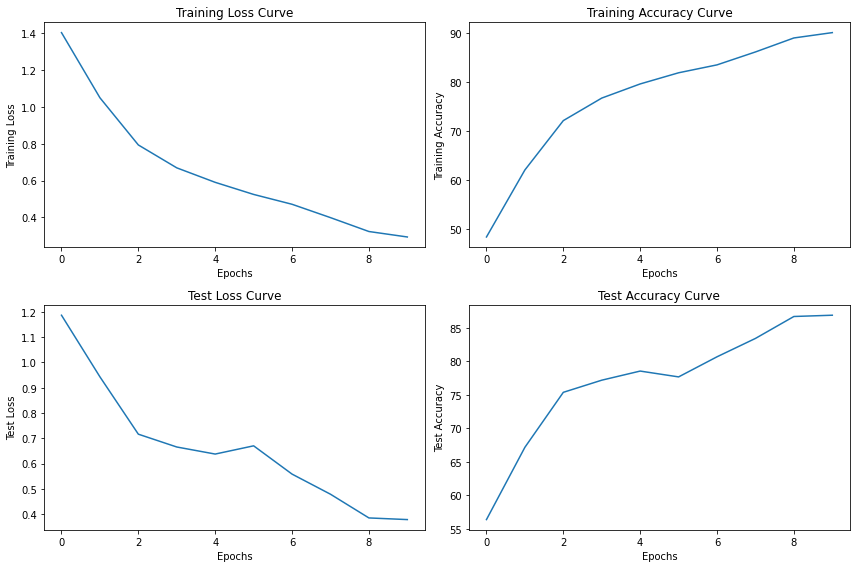

In [11]:
visualize_graph(filepath, train_loss, test_loss, train_accuracy, test_accuracy)

Visualizing the predictions of the model

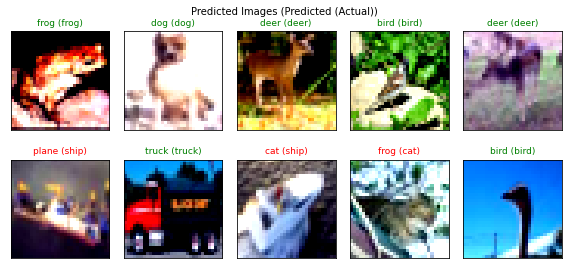

In [12]:
visualize_predictions(filepath, device, model, test_loader, classes)

Visualizing the misclassified images of the model

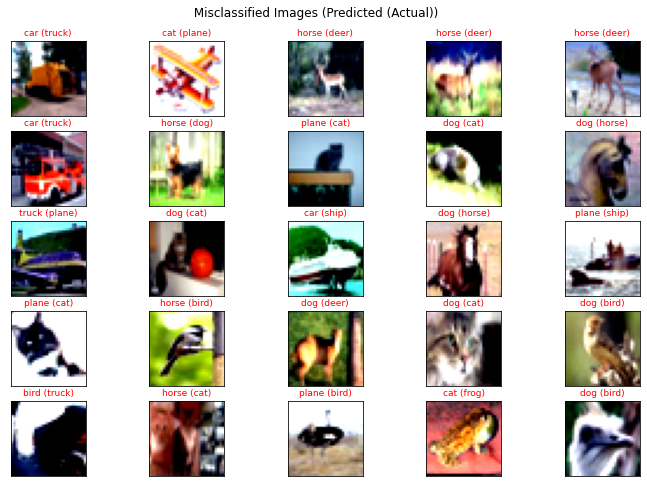

In [13]:
visualize_misclassified(filepath, misclassified)

Visualizing the per-class accuracies of the model

In [14]:
classwise_accuracy(device, model, classes, test_loader)

Accuracy of plane : 90 %
Accuracy of   car : 100 %
Accuracy of  bird : 85 %
Accuracy of   cat : 79 %
Accuracy of  deer : 82 %
Accuracy of   dog : 85 %
Accuracy of  frog : 96 %
Accuracy of horse : 89 %
Accuracy of  ship : 94 %
Accuracy of truck : 93 %


## S7 - Solution Quiz:
1. What is the final accuracy of the model?  
   87.47%  
2. Have you used depthwise separable convolution?  
   Yes
3. Have you used dilated kernels?  
   Yes    
4. What are the total number of parameters in the model?  
   439,808 parameters  

## Quiz 6: 
1. When would you want to use a 1x1?
  * To reduce the number of channels.
  * To increase the number of channels, instead of a 3x3 to save the total number of parameters on a constrained hardware.
  * To increase the number of channels to increase the available pixel resolution.

2. Checkerboard issues may be caused due to:
  * Using stride more than 1.
  * Using deconvolution or transpose convolution.
  * Using an image scaled using bilinear interpolation.

3. Atrous or Dilated convolution can be used for:
  * Image (or instance) segmentation.
  * Super resolution related problems.
  * Denoising images.
  * Keypoint detection.

4. Which is better for capturing the global context in a channel?  
   Atrous convolution

5. Pixel Shuffle algorithm:  
   was introduced to fix checkerboard issues.

6. Consider a layer with resolution 64x64x128. In the next layer, we intend to add normal 256 kernels of size 3x3. Assume this adds X number of parameters. If instead, we add depthwise separable convolution, we would add Y number of parameters. The X:Y ratio is close or equal to?  
   8.69:1

7. Consider a layer with resolution 128x128x256. In the next layer, we intend to add normal 512 kernels of size 3x3. Assume this adds X number of parameters.If instead, we add separable convolutions (3x1 followed by 1x3), we would add Y number of parameters. The X:Y ratio is close or equal to?   
   2:1

8. Select all that apply for grouped convolution:
  * Different kernels must have the same number of channels.
  * Different kernel types can have different sizes.
  * The output resolution from each kernel type must be the same.

9. Select all that are true:
  * It is advisable to use dilated kernels alone (i.e. without normal 3*3 convolutions)
  * Grouped convolution should help in handling scenarios where object sizes might be different.
  * Dilated kernels are beneficial when "dense reolution" channels are expected in the network.
  * Spatially separable convolutions are preferred early in the network.
  * If only RAM is an issue, one would prefer depthwise over spatially separable convolutions.
  * Dilated convolutions would be better for scene classification networks as compared to object detection networks.

10. If memory is not an issue, what other advantage depthwise separable convolutions might provide because of which you might want to use it?  
   Reduced number of total multiplications.

11. A 3x3(x3) kernel would move 9x3 times on 5x5x3 image. This gives us 27 moves. Assume each move equals 1 computation unit. Let us say we have an input of 7x7x128. Assuming we need to increase channel size to 256. We use two approaches, normal convolution  (needing X moves) and depthwise separable convolution (needing Y moves).What is X:Y close or equal to?  
   8.69:1  

### That's all Folks!